# Gaussian mixture model example

## Model

We are interested in estimating the labels and means of a Gaussian mixture model (GMM) given $N$ data points.
Specifically, we observe $Y_1,\dots,Y_N\overset{\mathrm{i.i.d.}}{\sim} \pi$, 
where $\pi$ is a GMM with $K\in\mathbb{N}$ Gaussian components:

$$
    \pi = \sum_{k=1}^K w_k \phi_{\mu_k,\tau_k}.
$$
Here, $\phi_{\mu,\sigma}$ is a $\mathcal{N}(\mu,\tau)$ distribution
which we parametrize with precision $\tau$.
We assume that the number of components $K$ is known, 
as are the precisions $\tau_k$ and weights $w_k$, $k=1,\dots,K$.

We can formulate the GMM as a hierarchical model by introducing discrete latent variables (labels)
$x_1,\dots,x_N\in\{1,\dots,K\}$
that indicate the component to which each observation belongs,
i.e., $y_n\sim\phi_{\mu_k,\sigma_k} \iff x_n=k$.
We can use the labels to rewrite the likelihood as a product over the sample and label indices:

$$
    \ell(y_{1:N}; \mu_{1:K}, x_{1:N}) 
    = \prod_{n=1}^N \prod_{k=1}^K (w_k \phi_{\mu_k,\tau_k}(y_n))^{\mathbb{I}(x_n=k)},
$$
where (by a slight abuse of notation) $\phi_{\mu,\tau}(y)$ is the density of a 
$\mathcal{N}(\mu,\tau)$ distribution evaluated at $y\in\mathbb{R}$.


### Prior distributions

We consider uninformative and independent prior distributions for each of the $K+N$ parameters.
Specifically, we use the known weights $w_{1:N}$ for each $x_n$ and 
assign an isotropic zero-mean Gaussian for the means:

$$
    X_n \sim \mathrm{Categorical}(w_1,\dots,w_N), \quad
    \mu_k \sim \mathcal{N}(0,\tau_0), \quad
    n\in[N] \text{ and } k\in[K],
$$
where we choose a label-common prior precision $\tau_0$.
In our experiemtns, $\tau_0=0.1$, reflecting little prior knowledge of the means $\mu_k$.


### Posterior distribution

We can write down the posterior density (up to proportionality)
by multiplying the likelihood and the priors:

$$
    p(x_{1:N},\mu_{1_K}\,|\,y_{1:N})\propto
    \left(\mathrm{Categorical}(w_1,\dots,w_N)^N \right) \times
    \left(\prod_{k=1}^K\phi_{0,\tau_0}(\mu_k)\right) \times
    \left(\prod_{n=1}^N \prod_{k=1}^K (w_k \phi_{\mu_k,\tau_k}(y_n))^{\mathbb{I}(x_n=k)}\right).
$$


### Gibbs sampling

We devise a Gibbs sampler to learn the labels and means of the GMM.
We first obtain the full conditional distributions,
which have a closed form due to the structure of the problem.

Specifically, the full conditional of each individual label $x_n$, $n\in[N]$ fixed,
can be obtained by working with the terms directly affected by $x_n$:

$$
    p(X_n=k\,|\,\mu_{1_K},y_{1:N})\propto 
    w_k\prod_{\tilde{k}}^K (w_{\tilde{k}} 
    \phi_{\mu_{\tilde{k}},\tau_{\tilde{k}}}(y_n))^{\mathbb{I}(k={\tilde{k}})}.
$$

In this case, all the indicator functions are 0 except for $\tilde{k}=k$, and so

$$
    p(X_n=k\,|\,\mu_{1_K},y_{1:N})\propto w_k\phi_{\mu_k,\tau_k}(y_n),
$$

a scaled Gaussian distribution.

Similarly, we can leverage the "complete the quadratic expression" trick to obtain the
full conditional of each mean $\mu_k$, which corresponds to a Gaussian centered at a scaled sample mean:

$$
    p(\mu_k\,|\,x_{1:N},y_{1:N})=\phi_{\tilde{y}_{(k)},\tilde{\tau}_{(k)}}(\mu_k),
$$

where $\tilde{y}_{(k)}$ and $\tilde{\tau}_{(k)}^2$ combine the sample 
(via the sample mean and sample variance) with the prior information on $\mu_k$ from the prior:

$$
    \tilde{y}_{(k)} = \frac{1}{\tilde{\tau}_{(k)}} \sum_{n=1}^N y_n \mathbb{I}(x_n=k),\\
    \tilde{\tau}_{(k)} =N_{(k)}+\tau_0,\\
    N_{(k)}=\sum_{n=1}^N \mathbb{I}(x_n=k).
$$

Here, $N_{(k)}$ is the number of samples currently in cluster $k$,
which ensures that only data points in each active cluster are averaged.
The quantity $N_{(k)}+\tau_0$ can be thought of as the posterior sample size,
which corresponds to the actual sample size plus the amount of information provided by the prior
in terms of sample size (denoted by the prior precision).

## Data generation

We generate $N=100$
from a mixture with $K=3$ Gaussians.
The true means are $\mu=(-7.5,0,7.5)$
with precisions $\tau_k=0.4$ for all $k$ and
with weights $w=(0.2,0.5,0.3)$.
Below we plot a histogram of the sample.

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import confusion_matrix
import sys,time
sys.path.insert(1, '../../src/')
import madmix
import gibbs
from concrete import *
import aux

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 40})
fig_path='fig/'
fig_path='../../../discrete-ergodic-flows-tex/fig/'

In [27]:
# data generation
np.random.seed(2023)
N=100
K=3
true_mu=np.array([-7.5,0,7.5])
true_tau=0.2*np.ones(3)
true_w=np.array([0.2,0.5,0.3])
tau0=0.1

x=np.random.choice(np.arange(K,dtype=int),size=N,p=true_w)
y=true_mu[x]+np.random.randn(N)/np.sqrt(true_tau[x])

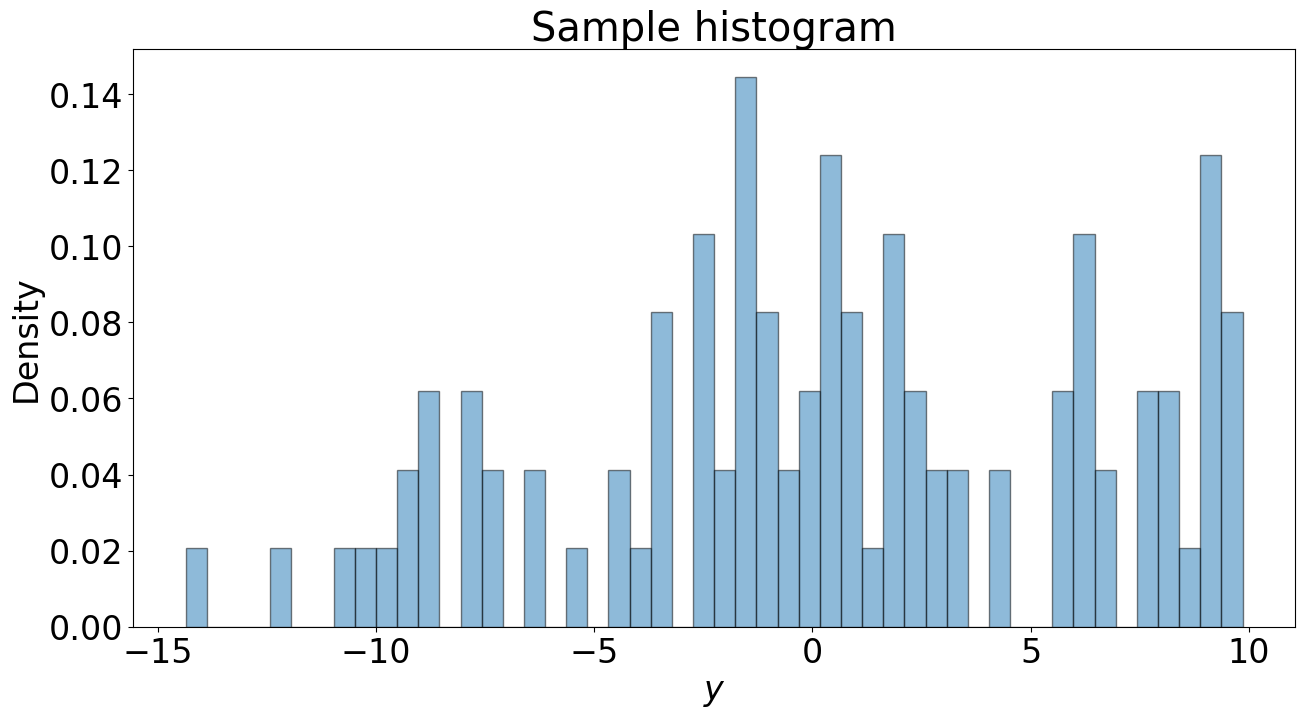

In [28]:
plt.hist(y,bins=50,alpha=0.5,ec='black',density=True)
plt.xlabel(r'$y$')
plt.ylabel('Density')
plt.title('Sample histogram');

## MadMix

In [4]:
########################
########################
# target specification #
########################
########################
def lp(xd,xc,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    xd     : (N,d) array with labels
    #    xc     : (K,d) array with means
    #    censor : (N,)  bool array, indices to censor; all Trues if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K) array with d conditionals 
    N,K,d=xd.shape[0],xc.shape[0],xc.shape[1]
    
    # get probs of all Xn's and K's for all d observations
    gauss_lp=-0.5*(y[:,np.newaxis,np.newaxis]-xc[np.newaxis,:,:])**2/np.sqrt(true_tau[np.newaxis,:,np.newaxis])-0.5*np.log(2*np.pi/true_tau[np.newaxis,:,np.newaxis])
    lprbs=np.moveaxis(gauss_lp+np.log(true_w[np.newaxis,:,np.newaxis]),2,0)
    prbs=np.exp(lprbs)
    prbs[prbs<1e-32]=1e-32
    prbs=prbs/np.sum(prbs,axis=1)[:,np.newaxis,:]
    lprbs=np.log(prbs)
    
    # for the joint, manually slice each prb
    if axis==None: 
        ext_lprb=np.zeros((d,N))
        for i in range(d): ext_lprb[i,:]=lprbs[i,np.arange(0,N),xd[:,i]]
        return np.sum(ext_lprb,axis=-1)
    
    # for pmf, look at axis entry of each d coordinate
    return lprbs[np.arange(0,d),axis,:]


def gen_grad_lp(xd): 
    # generate the score function for Hamiltonian dynamics
    #
    # inputs:
    #    xd     : (N,d) array with current labels
    # outputs:
    #   grad_lp : function, vectorized score function ((K,d)->(K,d))
    
    idx=(xd==np.arange(0,K,dtype=int)[:,np.newaxis,np.newaxis])       #(K,N,d)
    N_pool=np.sum(idx,axis=1)                                         #(K,d)
    tau_pool=N_pool+tau0                                              #(K,d)
    y_pool=np.sum(y[np.newaxis,:,np.newaxis]*idx,axis=1)/tau_pool     #(K,d)
    def mygrad_lp(xc): return -tau_pool*(xc-y_pool)                   #((K,d)->(K,d))
    return mygrad_lp

In [29]:
########################
########################
#    Mad Mix approx    #
########################
########################
# reference specification
np.random.seed(2023)
mu_ref=true_mu+np.random.randn(K)*0.3
print('Reference mu: '+str(mu_ref))
tau_ref=np.array([0.25,0.25,0.25])
def randq0(size):
    rxd  = np.random.randint(low=0,high=K,size=(N,size))
    rud  = np.random.rand(N,size)
    rxc  = mu_ref[:,np.newaxis]+np.random.randn(K,size)/np.sqrt(tau_ref[:,np.newaxis])
    rrho = np.random.laplace(size=(K,size))
    ruc  = np.random.rand(size)
    return rxd,rud,rxc,rrho,ruc

def lq0(xd,ud,xc,rho,uc):
    lqd=-np.log(K)*np.ones(xd.shape[1])
    lqc=-0.5*np.sum((xc-mu_ref[:,np.newaxis])**2,axis=0)*tau_ref-0.5*xc.shape[0]*np.log(2*np.pi/tau_ref)
    return lqd+lqc


# flow settings
steps=50
L=10
epsilon=0.1
xi=np.pi/16

Reference mu: [-7.28649794 -0.09734549  7.19943881]


In [30]:
# initial values
xd  = np.arange(0,K)*np.ones((N,K),dtype=int)
ud  = 0.5*np.ones((N,K))
xc  = mu_ref*np.ones((K,K)).T
rho = np.zeros((K,K))
uc  = 0.5*np.ones(K)

In [31]:
# cache settings
RUN=False # if False then load cache; else regenerate sample
path='madmix_cache/'

# sampling settings
sample_size=1000
burn_in=100

if RUN:
    print('Sampling')
    xd_,ud_,xc_,rho_,uc_=madmix.randqN(sample_size,steps,randq0,L,epsilon,lp,gen_grad_lp,xi)
    xd,ud,xc,rho,uc=xd_[:,burn_in:],ud_[:,burn_in:],xc_[:,burn_in:],rho_[:,burn_in:],uc_[burn_in:]
    print()
    print('Cacheing results')
    aux.pkl_save(xd,path+'xd')
    aux.pkl_save(ud,path+'ud')
    aux.pkl_save(xc,path+'xc')
    aux.pkl_save(rho,path+'rho')
    aux.pkl_save(uc,path+'uc')
else:
    print('Loading cached samples')
    xd=aux.pkl_load(path+'xd')
    ud=aux.pkl_load(path+'ud')
    xc=aux.pkl_load(path+'xc')
    rho=aux.pkl_load(path+'rho')
    uc=aux.pkl_load(path+'uc')

Loading cached samples


In [32]:
print(np.mean(xc,axis=-1))

[-8.19329234 -0.23930252  7.40658365]


In [33]:
# estimate probabilities of each xn
madmix_prbs=np.sum(xd==np.arange(0,K,dtype=int)[:,np.newaxis,np.newaxis],axis=-1)
madmix_prbs=(madmix_prbs/np.sum(madmix_prbs,axis=0)[np.newaxis,:]).T

Text(0.5, 1.0, 'Mad Mix posterior density of each mean')

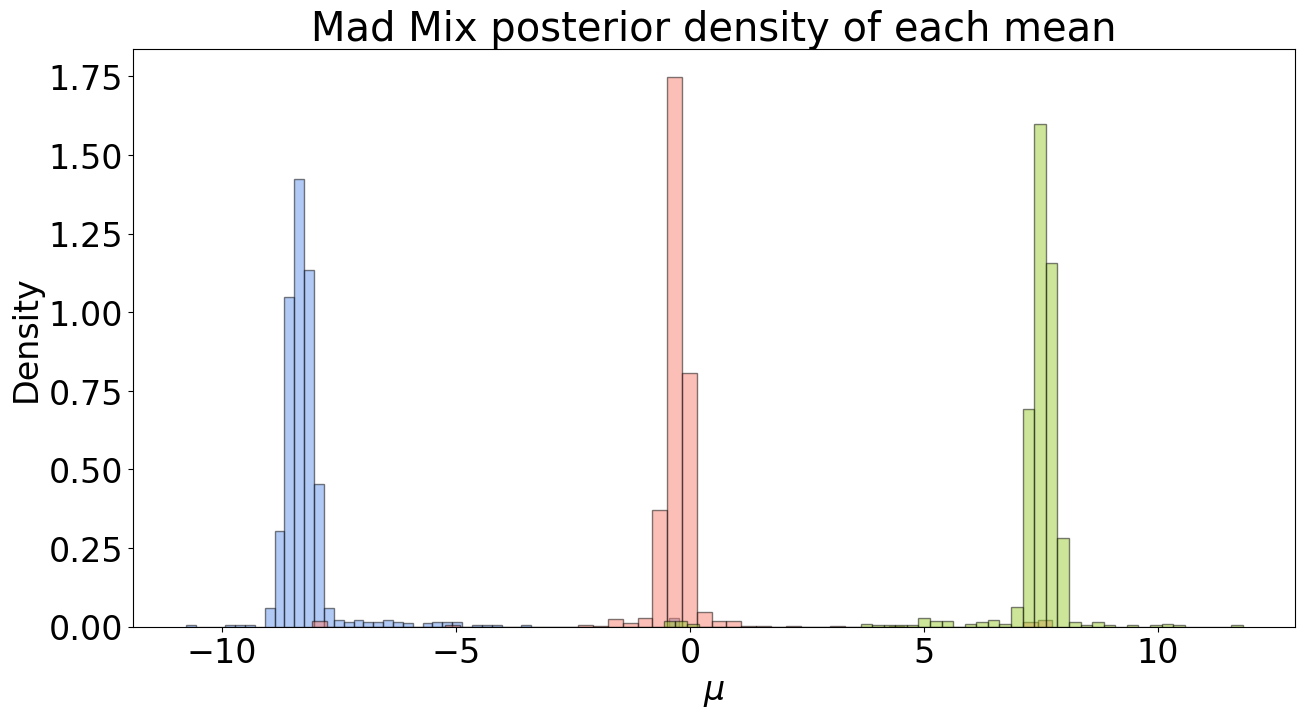

In [34]:
#########################
#########################
# means posterior dist  #
#########################
#########################

# madmix
plt.hist(xc[0,:],alpha=0.5,ec='black', density=True,
         color='cornflowerblue',bins=50,label=r'$k=1$, MadMix (ours)')
plt.hist(xc[1,:],alpha=0.5,ec='black',density=True,
         color='salmon',bins=50,label=r'$k=2$, MadMix (ours)')
plt.hist(xc[2,:],alpha=0.5,ec='black',density=True,
         color='yellowgreen',bins=50,label=r'$k=3$, MadMix (ours)');
plt.xlabel(r'$\mu$')
plt.ylabel('Density')
plt.title('Mad Mix posterior density of each mean')

## Gibbs sampler

Now we run a Gibbs sampler for 1,000 steps after burn-in 
(which will consist of 90% of the total steps taken,
i.e., we run 10,000 the sampler for 10,000 steps and take 
the last 1,000 as the sample).

In [50]:
########################
########################
#    Gibbs sampling    #
########################
########################
np.random.seed(2023)
gibbs_ss=5000
pred_x,pred_mu=gibbs.gibbs_gmm(y,true_w,true_tau,tau0,steps=gibbs_ss,burnin_pct=0.80,verbose=True,seed=1)

In [37]:
#aux.pkl_save(pred_x,'pred_x')
#aux.pkl_save(pred_mu,'pred_mu')

In [51]:
print(np.mean(pred_mu,axis=-1))

[-8.41597589 -0.64252449  6.8207822 ]


In [52]:
confusion_matrix(x,pred_x[:,-1])

array([[17,  5,  0],
       [ 0, 46,  5],
       [ 0,  1, 26]])

In [53]:
# estimate probabilities of each xn
gibbs_prbs=np.sum(pred_x==np.arange(0,K,dtype=int)[:,np.newaxis,np.newaxis],axis=-1)
gibbs_prbs=(gibbs_prbs/np.sum(gibbs_prbs,axis=0)[np.newaxis,:]).T

## Concrete approximation

In [16]:
########################
########################
#       Concrete       #
########################
########################
flows     = aux.pkl_load('sockeye/gmm_flows')
losses    = aux.pkl_load('sockeye/gmm_losses')
cpu_times = aux.pkl_load('sockeye/gmm_cpu_times')
sim_size  = len(flows)
max_iters = losses.shape[-1]
print('Total training time: '+str(cpu_times.sum()/3600)+' hours')

Total training time: 89.61011178342807 hours


Text(0.5, 1.0, 'Concrete RealNVP training loss traceplots')

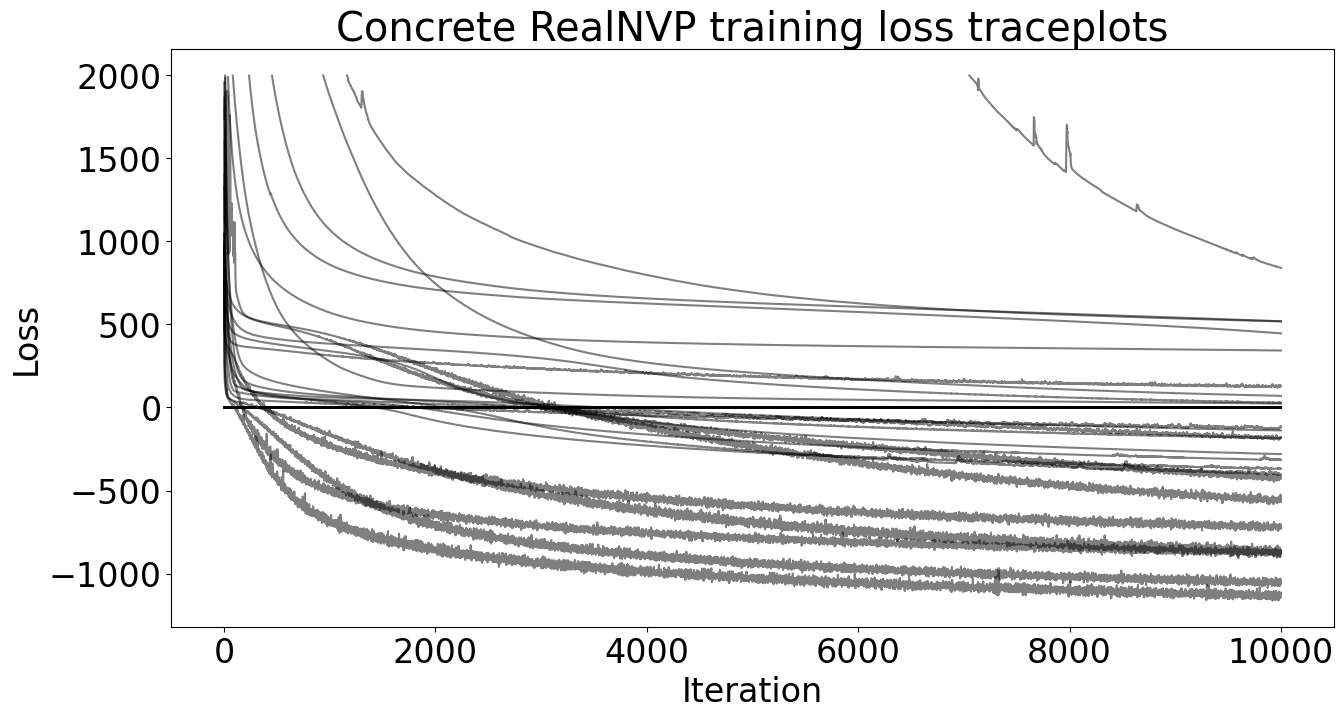

In [41]:
# loss traceplot
threshold=2000
for i in range(sim_size): plt.plot(np.arange(max_iters)[losses[i,:]<threshold],losses[i,losses[i,:]<threshold],'-k',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Concrete RealNVP training loss traceplots')

In [42]:
# retrieve best flow
i_star=np.argmin(losses[:,-1])
best_flow=flows[i_star]
print('Optimal flow: '+str(i_star))

Optimal flow: 125


In [43]:
# generate sample from optimal flow
torch.manual_seed(1)
flow_sample=best_flow.sample(10000)

In [44]:
# estimate means
concrete_means=flow_sample[:,:3].detach().numpy()
print('Concrete estimated means: '+str(np.mean(concrete_means,axis=0)))

Concrete estimated means: [-8.05313    -0.65251786  6.3028083 ]


In [45]:
# calculate probabilities of each xn

# first, convert (nsamples,300) array into (nsamples,100,3) array of ints
concrete_prbs=np.zeros(gibbs_prbs.shape)
conc_x_sample=flow_sample[:,3:]
conc_x_sample=np.exp(conc_x_sample.detach().numpy())
tmp_conc_x_sample=np.zeros((conc_x_sample.shape[0],N,K))
for n in range(N): tmp_conc_x_sample[:,n,:]=conc_x_sample[:,K*n+np.arange(0,3,dtype=int)]
tmp_conc_x_sample=np.argmax(tmp_conc_x_sample,axis=-1).T

# then estimate probabilities of each xn
concrete_prbs=np.sum(tmp_conc_x_sample==np.arange(0,K,dtype=int)[:,np.newaxis,np.newaxis],axis=-1)
concrete_prbs=(concrete_prbs/np.sum(concrete_prbs,axis=0)[np.newaxis,:]).T

## Diagnostics

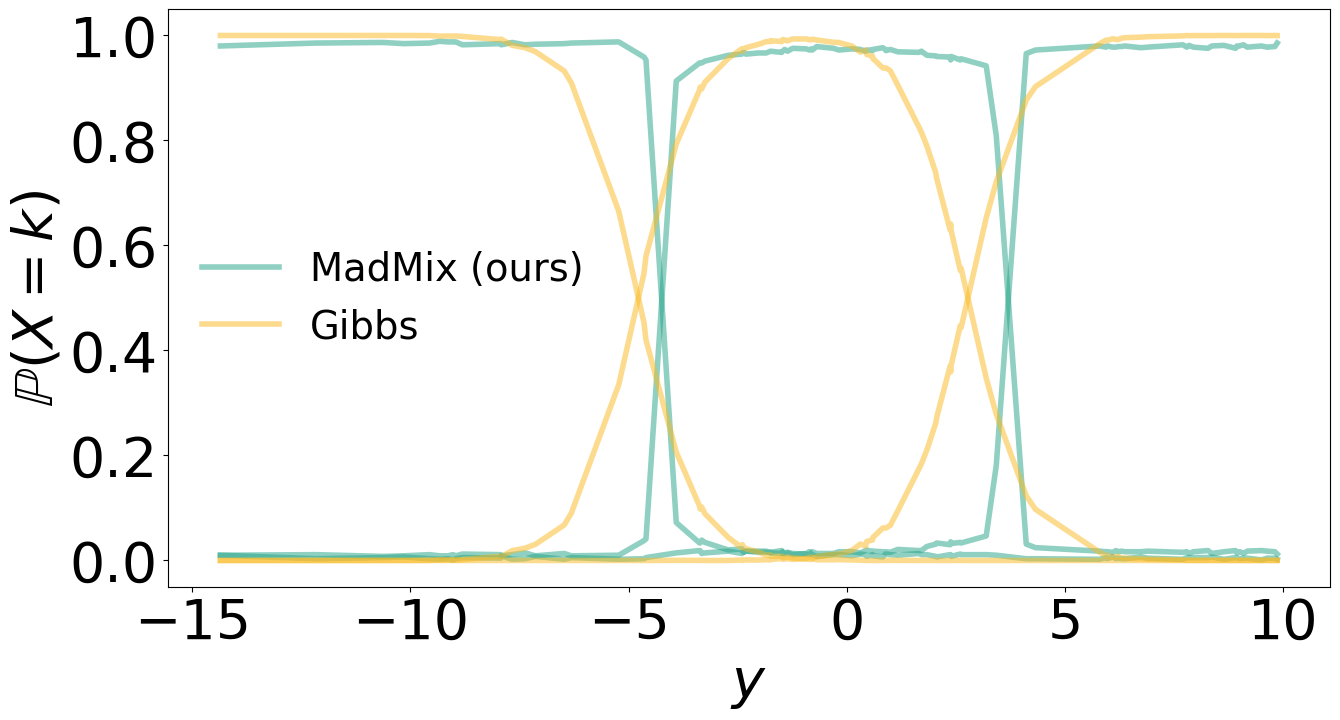

In [74]:
#########################
#########################
# xn probs estimation  #
#########################
#########################

idx=np.argsort(y)

# plt settings
lw=4
alpha=0.5
ls='solid'

plt.plot(y[idx],madmix_prbs[idx,0],label='MadMix (ours)', color='#20A386FF', alpha=alpha, lw=lw,ls=ls)
plt.plot(y[idx],madmix_prbs[idx,1],label='', color='#20A386FF', alpha=alpha, lw=lw,ls=ls)
plt.plot(y[idx],madmix_prbs[idx,2],label='', color='#20A386FF', alpha=alpha, lw=lw,ls=ls)

plt.plot(y[idx],gibbs_prbs[idx,0],label='Gibbs', color='#FBB91FFF', alpha=alpha, lw=lw,ls=ls)
plt.plot(y[idx],gibbs_prbs[idx,1],label='', color='#FBB91FFF', alpha=alpha, lw=lw,ls=ls)
plt.plot(y[idx],gibbs_prbs[idx,2],label='', color='#FBB91FFF', alpha=alpha, lw=lw,ls=ls)

#plt.plot(y[idx],concrete_prbs[idx,0],label='Concrete', color='#87216BFF', alpha=alpha-0.1, lw=lw,ls=ls)
#plt.plot(y[idx],concrete_prbs[idx,1],label='', color='#87216BFF', alpha=alpha-0.1, lw=lw,ls=ls)
#plt.plot(y[idx],concrete_prbs[idx,2],label='', color='#87216BFF', alpha=alpha-0.1, lw=lw,ls=ls)

plt.legend(fontsize='x-small',frameon=False,loc='center left')
plt.xlabel(r'$y$')
plt.ylabel(r'$\mathbb{P}(X=k)$')
plt.yticks(ticks=np.arange(0,6)/5)
#plt.ylim(0,1.1)
plt.savefig(fig_path+'gmm_label_prbs.pdf', dpi=300, bbox_inches='tight')

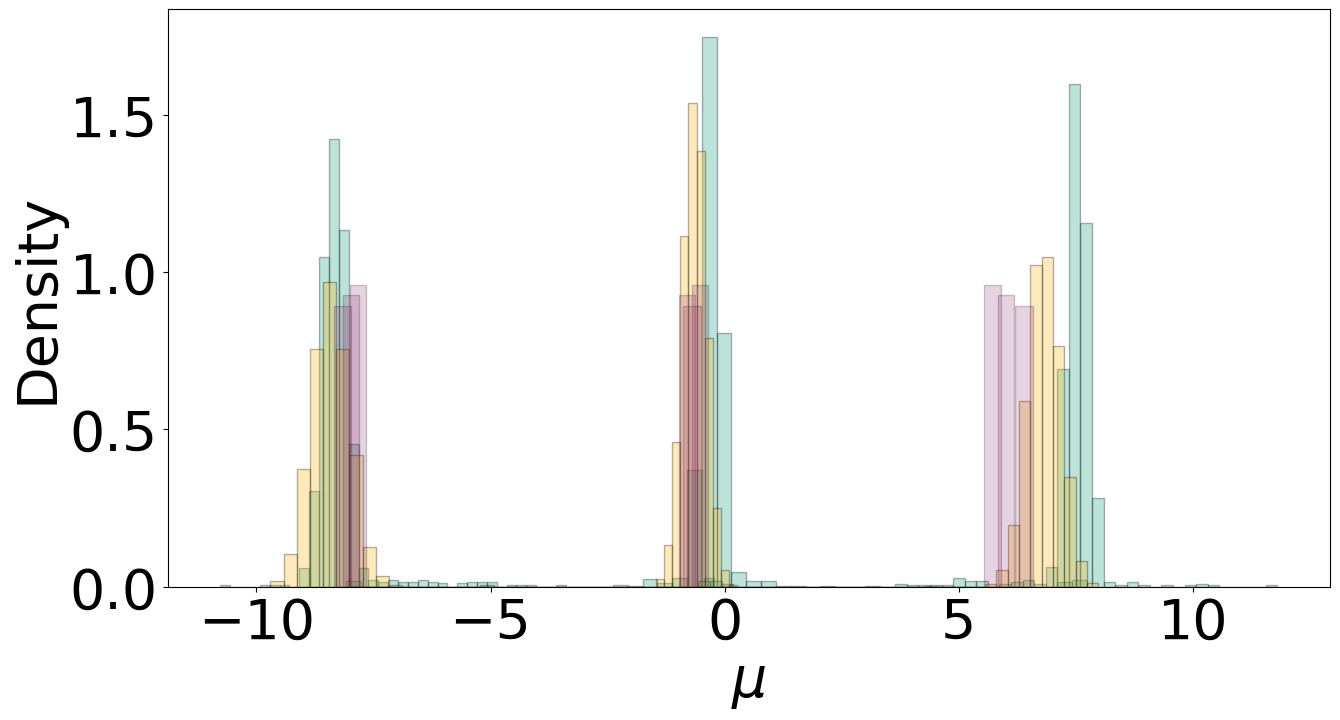

In [70]:
#########################
#########################
# means posterior dist  #
#########################
#########################

# plt settings
alpha=0.3

# madmix
plt.hist(xc[0,:],alpha=alpha,ec='black', density=True,
         color='#20A386FF',bins=50,label='MadMix (ours)')
plt.hist(xc[1,:],alpha=alpha,ec='black',density=True,
         color='#20A386FF',bins=50,label='')
plt.hist(xc[2,:],alpha=alpha,ec='black',density=True,
         color='#20A386FF',bins=50,label='')


# gibbs
plt.hist(pred_mu[0,:],alpha=alpha,ec='black', density=True,
         color='#FBB91FFF',bins=10,label='Gibbs')
plt.hist(pred_mu[1,:],alpha=alpha,ec='black',density=True,
         color='#FBB91FFF',bins=10,label='')
plt.hist(pred_mu[2,:],alpha=alpha,ec='black',density=True,
         color='#FBB91FFF',bins=10,label='')


# concrete
plt.hist(concrete_means[0,:],alpha=0.2,ec='black', density=True,
         color='#87216BFF',bins=40,label='Concrete')
plt.hist(concrete_means[1,:],alpha=0.2,ec='black',density=True,
         color='#87216BFF',bins=40,label='')
plt.hist(concrete_means[2,:],alpha=0.2,ec='black',density=True,
         color='#87216BFF',bins=40,label='')



#plt.legend(fontsize='x-small',frameon=False,loc='upper left')
#plt.ylim(0.,2.)
plt.xlabel(r'$\mu$')
plt.ylabel('Density')
plt.savefig(fig_path+'gmm_means_post.pdf', dpi=300, bbox_inches='tight')

(0.0, 1.4)

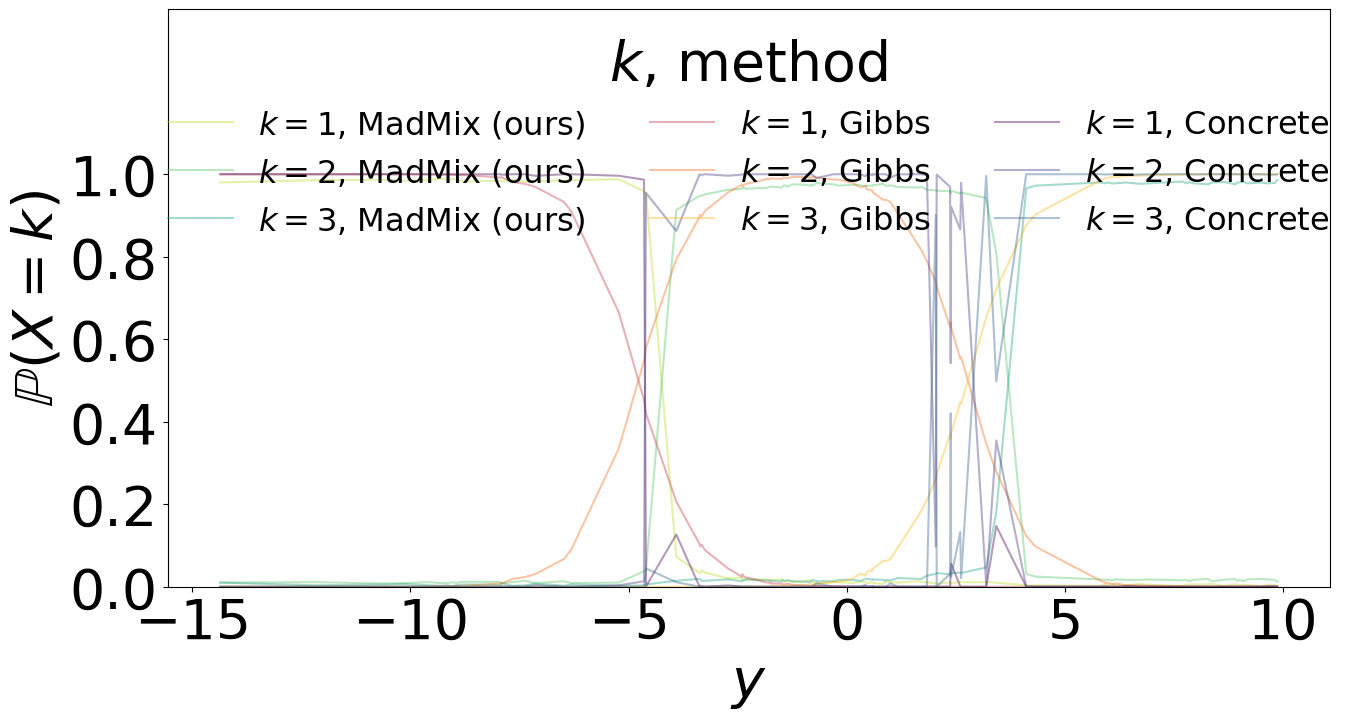

In [63]:
#########################
#########################
# xn probs estimation  #
#########################
#########################

idx=np.argsort(y)

# plt settings
lw=1.5
alpha=0.4

madmix_colors=['#bade28','#56c667','#20a386']
plt.plot(y[idx],madmix_prbs[idx,0],label=r'$k=1$, MadMix (ours)', color=madmix_colors[0], alpha=alpha, lw=lw)
plt.plot(y[idx],madmix_prbs[idx,1],label=r'$k=2$, MadMix (ours)', color=madmix_colors[1], alpha=alpha, lw=lw)
plt.plot(y[idx],madmix_prbs[idx,2],label=r'$k=3$, MadMix (ours)', color=madmix_colors[2], alpha=alpha, lw=lw)

gibbs_colors=['#C43C4EFF','#F17020FF','#FBB91FFF']
plt.plot(y[idx],gibbs_prbs[idx,0],label=r'$k=1$, Gibbs', color=gibbs_colors[0], alpha=alpha, lw=lw)
plt.plot(y[idx],gibbs_prbs[idx,1],label=r'$k=2$, Gibbs', color=gibbs_colors[1], alpha=alpha, lw=lw)
plt.plot(y[idx],gibbs_prbs[idx,2],label=r'$k=3$, Gibbs', color=gibbs_colors[2], alpha=alpha, lw=lw)

concrete_colors=['#440154FF','#453781FF','#32648EFF']
plt.plot(y[idx],concrete_prbs[idx,0],label=r'$k=1$, Concrete', color=concrete_colors[0], alpha=alpha, lw=lw)
plt.plot(y[idx],concrete_prbs[idx,1],label=r'$k=2$, Concrete', color=concrete_colors[1], alpha=alpha, lw=lw)
plt.plot(y[idx],concrete_prbs[idx,2],label=r'$k=3$, Concrete', color=concrete_colors[2], alpha=alpha, lw=lw)

plt.legend(fontsize='xx-small',title=r'$k$, method',ncols=3,frameon=False,loc='upper center')
plt.xlabel(r'$y$')
plt.ylabel(r'$\mathbb{P}(X=k)$')
plt.yticks(ticks=np.arange(0,6)/5)
plt.ylim(0,1.4)
#plt.savefig(fig_path+'gmm_label_prbs2.pdf', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Density')

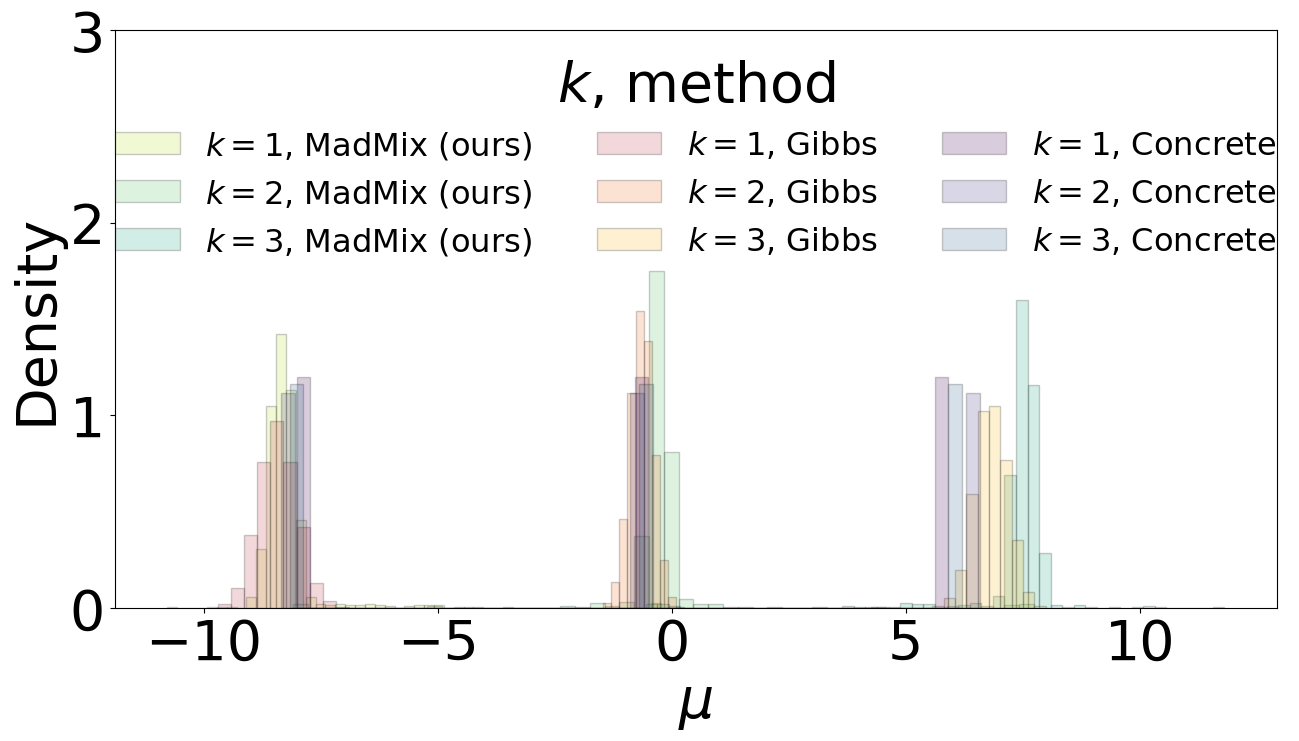

In [68]:
#########################
#########################
# means posterior dist  #
#########################
#########################

# madmix
plt.hist(xc[0,:],alpha=0.2,ec='black', density=True,
         color=madmix_colors[0],bins=50,label=r'$k=1$, MadMix (ours)')
plt.hist(xc[1,:],alpha=0.2,ec='black',density=True,
         color=madmix_colors[1],bins=50,label=r'$k=2$, MadMix (ours)')
plt.hist(xc[2,:],alpha=0.2,ec='black',density=True,
         color=madmix_colors[2],bins=50,label=r'$k=3$, MadMix (ours)')


# gibbs
plt.hist(pred_mu[0,:],alpha=0.2,ec='black', density=True,
         color=gibbs_colors[0],bins=10,label=r'$k=1$, Gibbs')
plt.hist(pred_mu[1,:],alpha=0.2,ec='black',density=True,
         color=gibbs_colors[1],bins=10,label=r'$k=2$, Gibbs')
plt.hist(pred_mu[2,:],alpha=0.2,ec='black',density=True,
         color=gibbs_colors[2],bins=10,label=r'$k=3$, Gibbs')


# concrete
plt.hist(concrete_means[0,:],alpha=0.2,ec='black', density=True,
         color=concrete_colors[0],bins=50,label=r'$k=1$, Concrete')
plt.hist(concrete_means[1,:],alpha=0.2,ec='black',density=True,
         color=concrete_colors[1],bins=50,label=r'$k=2$, Concrete')
plt.hist(concrete_means[2,:],alpha=0.2,ec='black',density=True,
         color=concrete_colors[2],bins=50,label=r'$k=3$, Concrete')



plt.legend(fontsize='xx-small',title=r'$k$, method',ncols=3,frameon=False,loc='upper center')
plt.ylim(0.,3.)
plt.xlabel(r'$\mu$')
plt.ylabel('Density')
#plt.savefig(fig_path+'gmm_means_post2.pdf', dpi=300, bbox_inches='tight')